# Определение тональности комментариев

# 1. Загрузка бибилиотек и данных

In [1]:
#pip install pymorphy2
# pip install pymorphy3
#pip install nltk
#pip install re
#pip install scikeras
# pip uninstall keras -y

In [3]:
import numpy as np

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('wordnet')
nltk.download('stopwords')

from string import punctuation

import pymorphy3

import re

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping


from scikeras.wrappers import KerasClassifier
import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erikf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erikf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'tensorflow.keras'

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "python"



In [ ]:
import tensorflow as tf
import keras

print("TF:", tf.__version__)
print("tf.keras:", tf.keras.__version__)
print("standalone keras:", keras.__version__)


TF: 2.20.0
tf.keras: 3.13.1
standalone keras: 3.13.1


In [ ]:
def creat_df():
    data_list = []
    with open("dataset.txt", encoding = 'utf-8') as file:
        for line in file:
            labels = line.split()[0]
            text = line[len(labels)+1:].strip()
            labels = labels.split(",")
            mask = [1 if "__label__NORMAL" in labels else 0,
                    1 if "__label__INSULT" in labels else 0,
                    1 if "__label__THREAT" in labels else 0,
                    1 if "__label__OBSCENITY" in labels else 0]
            data_list.append((text, *mask))
    return pd.DataFrame(data_list, columns=["comment", "normal", "insult", "threat", "obscenity"])

In [ ]:
df = creat_df()
df

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


In [ ]:
df2 = pd.read_csv('labeled.csv')
df2

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


Датасеты созданы под разные семантические задачи, так что будем обучать две модели, одну для тональности, другу просто для классификации токсичности

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248290 entries, 0 to 248289
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    248290 non-null  object
 1   normal     248290 non-null  int64 
 2   insult     248290 non-null  int64 
 3   threat     248290 non-null  int64 
 4   obscenity  248290 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [ ]:
df.duplicated().sum()

np.int64(6)

In [ ]:
df2.duplicated().sum()

np.int64(0)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
normal,248284.0,0.820355,0.383892,0.0,1.0,1.0,1.0,1.0
insult,248284.0,0.148322,0.355420,0.0,0.0,0.0,0.0,1.0
threat,248284.0,0.048432,0.214679,0.0,0.0,0.0,0.0,1.0
obscenity,248284.0,0.017162,0.129874,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.head(5)

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0


In [ ]:
df2.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


# Лемматизация + предобработка

## Очистка комментария

In [ ]:
def clean_comment(comment):
    if not isinstance(comment, str):
        return ''
    
    urls = re.findall(r'https?://\S+|www\.\S+', comment)
    
    cleaned = re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', ' ', comment)
    
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    cleaned = re.sub("ё", "е", cleaned)

    
    if urls:
        cleaned += ' ' + ' '.join(urls)

    cleaned = cleaned.lower()
    
    return cleaned.strip()

In [ ]:
df['comment_clean'] = df['comment'].apply(clean_comment)

C:\Users\erikf\AppData\Local\Temp\ipykernel_26132\2762205320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_clean'] = df['comment'].apply(clean_comment)


In [ ]:
df2['comment_clean'] = df2['comment'].apply(clean_comment)

## Удаление стоп слов

In [ ]:
stop_words = set(stopwords.words('russian'))

In [ ]:
def remove_stopwords(comment):
    tokens = comment.split(' ')
    return ' '.join([word for word in tokens if word.lower() not in stop_words])

In [ ]:
df['comment_without_stop_words'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))

C:\Users\erikf\AppData\Local\Temp\ipykernel_26132\2137007685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_without_stop_words'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))


In [ ]:
df2['comment_without_stop_words'] = df2['comment_clean'].apply(lambda x: remove_stopwords(x))


## Токенизация

In [ ]:
def tokenize_comment(comment):
    return word_tokenize(comment, language='russian')

In [ ]:
df['comment_tokenize'] = df['comment_without_stop_words'].apply(tokenize_comment)

C:\Users\erikf\AppData\Local\Temp\ipykernel_26132\495641482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_tokenize'] = df['comment_without_stop_words'].apply(tokenize_comment)


In [ ]:
df2['comment_tokenize'] = df2['comment_without_stop_words'].apply(tokenize_comment)

In [ ]:
df.head()

,comment,normal,insult,threat,obscenity,comment_clean,comment_without_stop_words,comment_tokenize
0,скотина! что сказать,0,1,0,0,скотина что сказать,скотина сказать,"[скотина, сказать]"
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0,я сегодня проезжала по рабочей и между домами ...,сегодня проезжала рабочей домами снитенко гомо...,"[сегодня, проезжала, рабочей, домами, снитенко..."
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0,очередной лохотрон зачем придумывать очередной...,очередной лохотрон придумывать очередной налог...,"[очередной, лохотрон, придумывать, очередной, ..."
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0,ретро дежавю сложно понять чужое сердце лиш ощ...,ретро дежавю сложно понять чужое сердце лиш ощ...,"[ретро, дежавю, сложно, понять, чужое, сердце,..."
4,а когда мы статус агрогородка получили?,1,0,0,0,а когда мы статус агрогородка получили,статус агрогородка получили,"[статус, агрогородка, получили]"


In [ ]:
df2.head(5)

,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдов то за что дебилы бл,верблюдов дебилы бл,"[верблюдов, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохлы это отдушина затюканого россиянина мол в...,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собаке собачья смерть,"[собаке, собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил это оскорбление доказанн...,"[страницу, обнови, дебил, это, оскорбление, до..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,"[убедил, страничный, пдф, скрипалей, отравила,..."


## Лемматизация

In [ ]:
from pymorphy3 import MorphAnalyzer

In [ ]:
morph = MorphAnalyzer()

In [ ]:
def lemmatize(text: list) -> list:
    lemmas = [morph.parse(token)[0].normal_form for token in text]

    return lemmas

In [ ]:
df['comment_lemmatize'] = df['comment_tokenize'].apply(lemmatize)

C:\Users\erikf\AppData\Local\Temp\ipykernel_26132\117964416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_lemmatize'] = df['comment_tokenize'].apply(lemmatize)


In [ ]:
df2['comment_lemmatize'] = df2['comment_tokenize'].apply(lemmatize)

In [ ]:
df.sample(5)

,comment,normal,insult,threat,obscenity,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize
38099,если б можно было хотя на минуточку :( 🙏 🙏 🙏,1,0,0,0,если б можно было хотя на минуточку,б хотя минуточку,"[б, хотя, минуточку]","[б, хотя, минуточка]"
84589,есть такое знаменитое правило даннинга крюгера...,0,1,0,0,есть такое знаменитое правило даннинга крюгера...,такое знаменитое правило даннинга крюгера суть...,"[такое, знаменитое, правило, даннинга, крюгера...","[такой, знаменитый, правило, даннинга, крюгер,..."
26214,уёбок свинорылый!,0,1,0,0,уебок свинорылый,уебок свинорылый,"[уебок, свинорылый]","[уебок, свинорылый]"
46681,"да, суслики они такие, горячие парни:-)",1,0,0,0,да суслики они такие горячие парни,суслики такие горячие парни,"[суслики, такие, горячие, парни]","[суслик, такой, горячий, парень]"
84595,а спросишь почему потому что все бабки от прод...,0,1,0,0,а спросишь почему потому что все бабки от прод...,спросишь почему бабки продажи идут карманы гре...,"[спросишь, почему, бабки, продажи, идут, карма...","[спросить, почему, бабка, продажа, идти, карма..."


In [ ]:
df2.sample(5)

,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize
10358,Ганкера в частной группе не беспокоили? А то п...,0.0,ганкера в частной группе не беспокоили а то по...,ганкера частной группе беспокоили началу дв св...,"[ганкера, частной, группе, беспокоили, началу,...","[ганкер, частный, группа, беспокоить, начало, ..."
12749,Прикольнее было на сдачу собирать шибанутые эк...,0.0,прикольнее было на сдачу собирать шибанутые эк...,прикольнее сдачу собирать шибанутые экспрессы ...,"[прикольнее, сдачу, собирать, шибанутые, экспр...","[прикольный, сдача, собирать, шибануть, экспре..."
8904,Можно кучевые облака создать Спутнику через ни...,0.0,можно кучевые облака создать спутнику через ни...,кучевые облака создать спутнику увидит правда ...,"[кучевые, облака, создать, спутнику, увидит, п...","[кучевой, облако, создать, спутник, увидеть, п..."
10322,"Хромокей? Нее, не слышал...\n",1.0,хромокей нее не слышал,хромокей слышал,"[хромокей, слышал]","[хромокей, слышать]"
12415,"О, у нас тоже только оклад поднимают на 4 , но...",0.0,о у нас тоже только оклад поднимают на но раз ...,оклад поднимают год сказали уровень инфляции с...,"[оклад, поднимают, год, сказали, уровень, инфл...","[оклад, поднимать, год, сказать, уровень, инфл..."


In [ ]:
df['comment_res'] =df["comment_lemmatize"].apply(lambda x: ' '.join(x))
df2['comment_res'] =df2["comment_lemmatize"].apply(lambda x: ' '.join(x))
df.sample(5)
df2.sample(5)

C:\Users\erikf\AppData\Local\Temp\ipykernel_26132\618061841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_res'] =df["comment_lemmatize"].apply(lambda x: ' '.join(x))


,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize,comment_res
5946,"Продолжай. На кого бы ты посмотрел, на очередн...",1.0,продолжай на кого бы ты посмотрел на очередног...,продолжай кого посмотрел очередного дауна шизо...,"[продолжай, кого, посмотрел, очередного, дауна...","[продолжать, кто, посмотреть, очередной, даун,...",продолжать кто посмотреть очередной даун шизои...
5850,"Как же вы ззаебали, съебитесь в по уже дауничи...",1.0,как же вы ззаебали съебитесь в по уже дауничи ...,ззаебали съебитесь дауничи ебитесь анальные жопы,"[ззаебали, съебитесь, дауничи, ебитесь, анальн...","[ззаебали, съебиться, даунич, ебиться, анальны...",ззаебали съебиться даунич ебиться анальный жопа
7148,Какой символизм! Колючая проволока как последн...,1.0,какой символизм колючая проволока как последни...,символизм колючая проволока последний заслон з...,"[символизм, колючая, проволока, последний, зас...","[символизм, колючий, проволока, последний, зас...",символизм колючий проволока последний заслон з...
8354,"вообще не стоит облизываться, серьезно, это од...",0.0,вообще не стоит облизываться серьезно это один...,вообще стоит облизываться серьезно это самых н...,"[вообще, стоит, облизываться, серьезно, это, с...","[вообще, стоить, облизываться, серьёзно, это, ...",вообще стоить облизываться серьёзно это самый ...
10298,Перемычка тоже огород. Да ещё и вентиль выключ...,0.0,перемычка тоже огород да еще и вентиль выключа...,перемычка огород вентиль выключается,"[перемычка, огород, вентиль, выключается]","[перемычка, огород, вентиль, выключаться]",перемычка огород вентиль выключаться


## Разделение на тестовую и тренировочную выборку

In [ ]:
df = df[["comment_res", "normal", "insult", "threat", "obscenity"]]
df2 = df2[["comment_res", "toxic"]]

In [ ]:
X = df["comment_res"].values
y = df[["normal", "insult", "threat", "obscenity"]].values

In [ ]:
X2 = df2["comment_res"].values
y2 = df2["toxic"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.8, random_state=42, stratify=y2)


## Обучение

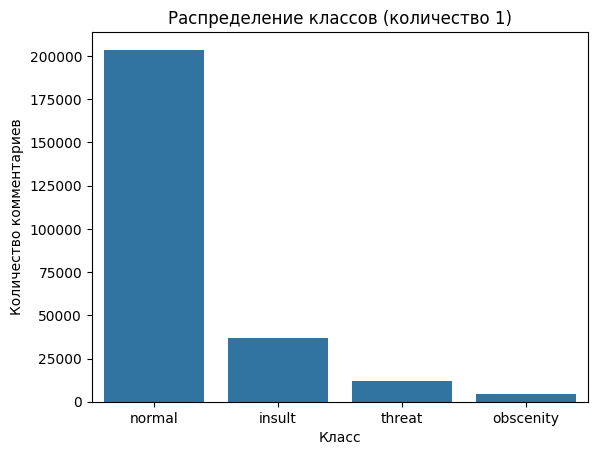

In [ ]:
class_counts = df[['normal','insult','threat','obscenity']].sum()

sns.barplot(
    x=class_counts.index,
    y=class_counts.values
)

plt.title('Распределение классов (количество 1)')
plt.ylabel('Количество комментариев')
plt.xlabel('Класс')
plt.show()

Heatmap решил не выводить, тк не понял его смысла

C:\Users\erikf\AppData\Local\Temp\ipykernel_26132\3912851465.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


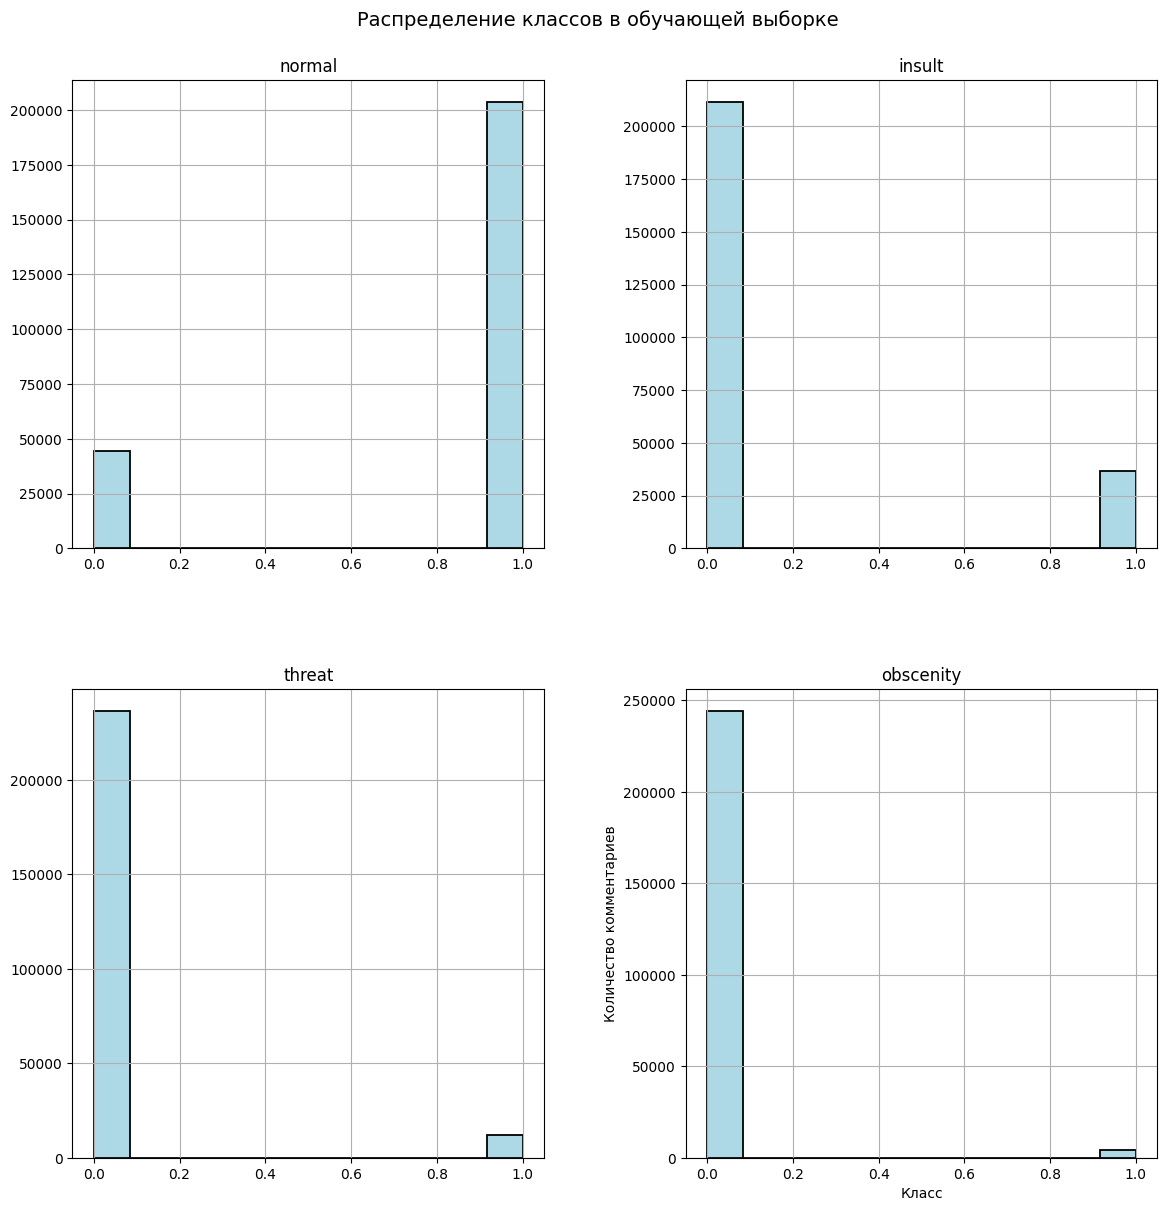

In [ ]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Распределение классов в обучающей выборке',y = 0.93,size = 14)
plt.xlabel("Класс")
plt.ylabel("Количество комментариев")
plt.show()

## Padding

In [ ]:
MAX_WORDS = 50000
MAX_LEN = 80

tokenizer = text.Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['comment_res'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=MAX_LEN)


In [ ]:
import pickle

with open("tokenizer_mult.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


# Задача 1

In [ ]:
def build_lstm():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [ ]:
def build_cnn():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [ ]:
def build_cnn_lstm():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Bidirectional(GRU(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True,  
    verbose=1
)

In [ ]:
model = build_cnn_lstm()

history = model.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - AUC: 0.9748 - loss: 0.1634 - val_AUC: 0.9837 - val_loss: 0.1283
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - AUC: 0.9888 - loss: 0.1053 - val_AUC: 0.9851 - val_loss: 0.1208
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - AUC: 0.9932 - loss: 0.0807 - val_AUC: 0.9841 - val_loss: 0.1235
Epoch 4/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - AUC: 0.9954 - loss: 0.0653 - val_AUC: 0.9818 - val_loss: 0.1337
Epoch 5/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 78s 63ms/step - AUC: 0.9965 - loss: 0.0561 - val_AUC: 0.9794 - val_loss: 0.1473
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
model2 = build_lstm()

history2 = model2.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 128s 99ms/step - AUC: 0.9889 - loss: 0.1083 - val_AUC: 0.9951 - val_loss: 0.0667
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - AUC: 0.9971 - loss: 0.0506 - val_AUC: 0.9946 - val_loss: 0.0662
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - AUC: 0.9982 - loss: 0.0373 - val_AUC: 0.9938 - val_loss: 0.0722
Epoch 4/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 128s 103ms/step - AUC: 0.9987 - loss: 0.0286 - val_AUC: 0.9922 - val_loss: 0.0824
Epoch 5/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 128s 103ms/step - AUC: 0.9991 - loss: 0.0232 - val_AUC: 0.9905 - val_loss: 0.0911
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
model3 = build_cnn()

history3 = model3.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - AUC: 0.9764 - loss: 0.1559 - val_AUC: 0.9867 - val_loss: 0.1154
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 74s 60ms/step - AUC: 0.9905 - loss: 0.0967 - val_AUC: 0.9865 - val_loss: 0.1153
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - AUC: 0.9938 - loss: 0.0769 - val_AUC: 0.9844 - val_loss: 0.1248
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


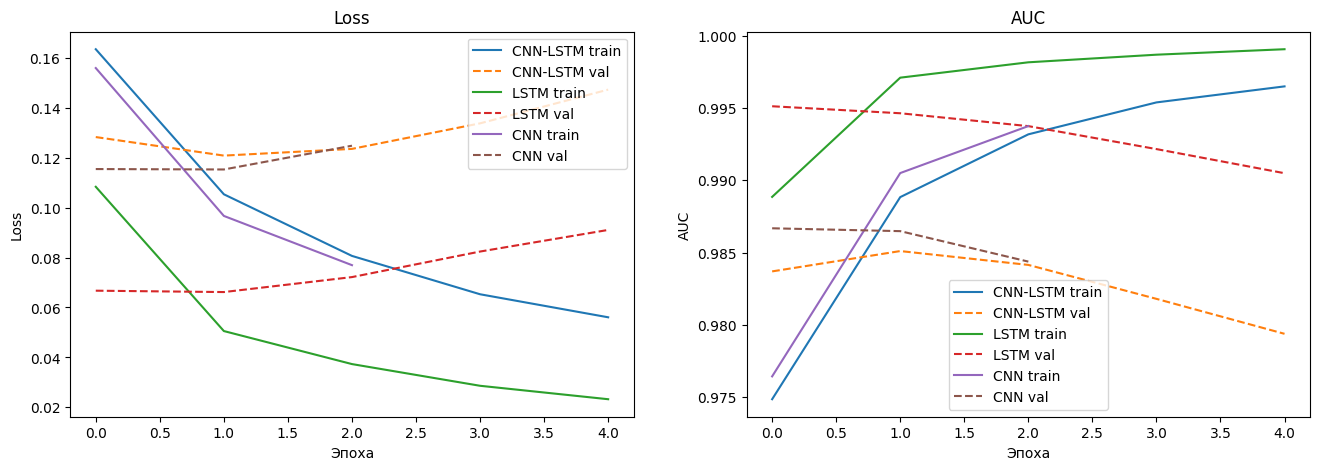

In [ ]:
def plot_history_multiclass(histories, model_names):
    plt.figure(figsize=(16,5))
    
    # Losss
    plt.subplot(1,2,1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} train')
        plt.plot(history.history['val_loss'], '--', label=f'{name} val')
    plt.title('Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    
    # AUC
    plt.subplot(1,2,2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['AUC'], label=f'{name} train')
        plt.plot(history.history['val_AUC'], '--', label=f'{name} val')
    plt.title('AUC')
    plt.xlabel('Эпоха')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.show()

plot_history_multiclass(
    [history, history2, history3], 
    ['CNN-LSTM', 'LSTM', 'CNN']
)


В этой задаче лучше всего себя показала модель LSTM, в приложении streamlit будем использовать ее

# Задача 2

In [ ]:
tokenizer2 = text.Tokenizer(num_words=MAX_WORDS)
tokenizer2.fit_on_texts(X2_train)

X2_train_seq = tokenizer2.texts_to_sequences(X2_train)
X2_test_seq = tokenizer2.texts_to_sequences(X2_test)

X2_train_pad = sequence.pad_sequences(X2_train_seq, maxlen=MAX_LEN)
X2_test_pad = sequence.pad_sequences(X2_test_seq, maxlen=MAX_LEN)


In [ ]:
with open("tokenizer_bin.pkl", "wb") as f:
    pickle.dump(tokenizer2, f)


In [ ]:
def build_cnn_lstm_binary():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    
    model.add(Bidirectional(GRU(64)))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    
    return model


In [ ]:
def build_lstm_binary():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(GRU(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [ ]:
def build_cnn_binary():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


## EarlyStopping

In [ ]:
early_stopping_bin = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

## LSTM

In [ ]:
model_lstm = build_lstm_binary()


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history_bin = model_lstm.fit(
    X2_train_pad, y2_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_bin]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - AUC: 0.7277 - loss: 0.5532 - val_AUC: 0.8918 - val_loss: 0.3959
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - AUC: 0.9649 - loss: 0.2225 - val_AUC: 0.9176 - val_loss: 0.3551
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - AUC: 0.9946 - loss: 0.0818 - val_AUC: 0.9135 - val_loss: 0.4464
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - AUC: 0.9984 - loss: 0.0329 - val_AUC: 0.9031 - val_loss: 0.5354
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - AUC: 0.9995 - loss: 0.0190 - val_AUC: 0.8981 - val_loss: 0.5848
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
y2_pred_prob = model_lstm.predict(X2_test_pad)
y2_pred = (y2_pred_prob > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y2_test, y2_pred_prob))
print(classification_report(y2_test, y2_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
ROC-AUC: 0.9167348328083551
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1918
         1.0       0.81      0.76      0.78       965

    accuracy                           0.86      2883
   macro avg       0.84      0.83      0.84      2883
weighted avg       0.86      0.86      0.86      2883



## CNN

In [ ]:
model_cnn = build_cnn_binary()


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history_bin2 = model_cnn.fit(
    X2_train_pad, y2_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_bin]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - AUC: 0.6464 - loss: 0.6073 - val_AUC: 0.8082 - val_loss: 0.5368
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - AUC: 0.9275 - loss: 0.3269 - val_AUC: 0.9238 - val_loss: 0.3285
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - AUC: 0.9895 - loss: 0.1222 - val_AUC: 0.9204 - val_loss: 0.3792
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - AUC: 0.9972 - loss: 0.0619 - val_AUC: 0.9166 - val_loss: 0.4282
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - AUC: 0.9989 - loss: 0.0346 - val_AUC: 0.9128 - val_loss: 0.4814
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
y2_pred_prob = model_cnn.predict(X2_test_pad)
y2_pred = (y2_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print("ROC-AUC:", roc_auc_score(y2_test, y2_pred_prob))
print(classification_report(y2_test, y2_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC-AUC: 0.9176408932015755
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      1918
         1.0       0.83      0.71      0.76       965

    accuracy                           0.85      2883
   macro avg       0.85      0.82      0.83      2883
weighted avg       0.85      0.85      0.85      2883



## Hybrid

In [ ]:
model_cnn_lstm_bin = build_cnn_lstm_binary()

c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history_cnn_lstm_bin = model_cnn_lstm_bin.fit(
    X2_train_pad, y2_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_bin]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - AUC: 0.6924 - loss: 0.5816 - val_AUC: 0.8764 - val_loss: 0.4625
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - AUC: 0.9500 - loss: 0.2676 - val_AUC: 0.9162 - val_loss: 0.3636
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - AUC: 0.9907 - loss: 0.1147 - val_AUC: 0.9045 - val_loss: 0.4420
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
y2_pred_prob = model_cnn_lstm_bin.predict(X2_test_pad)
y2_pred = (y2_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print("ROC-AUC:", roc_auc_score(y2_test, y2_pred_prob))
print(classification_report(y2_test, y2_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
ROC-AUC: 0.8725907276037757
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      1918
         1.0       0.84      0.26      0.40       965

    accuracy                           0.74      2883
   macro avg       0.78      0.62      0.62      2883
weighted avg       0.76      0.74      0.69      2883



## Graphics

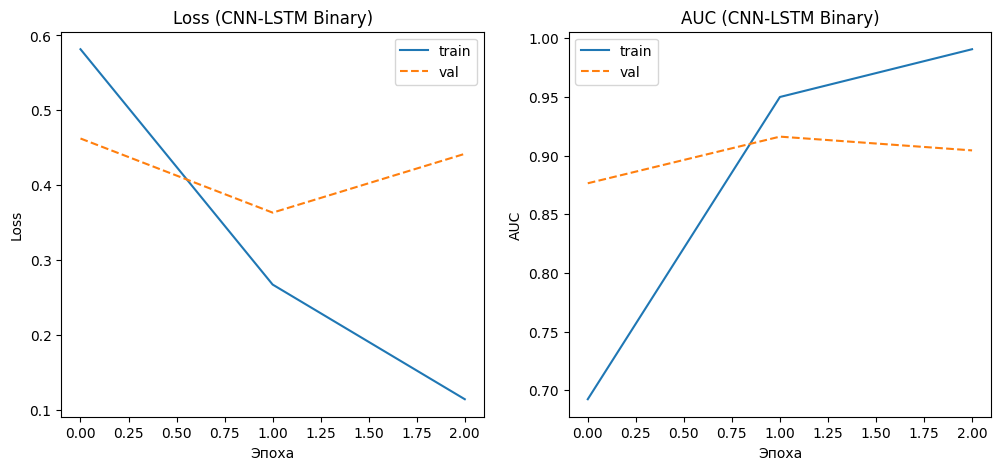

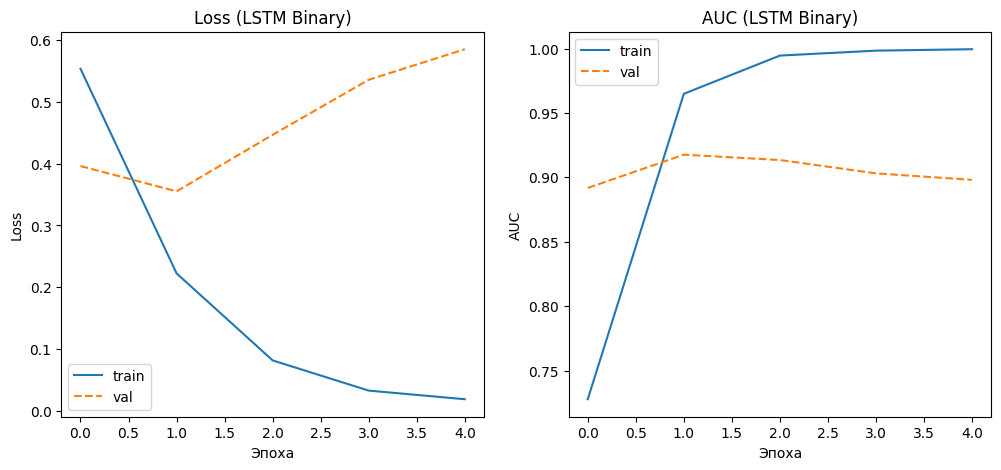

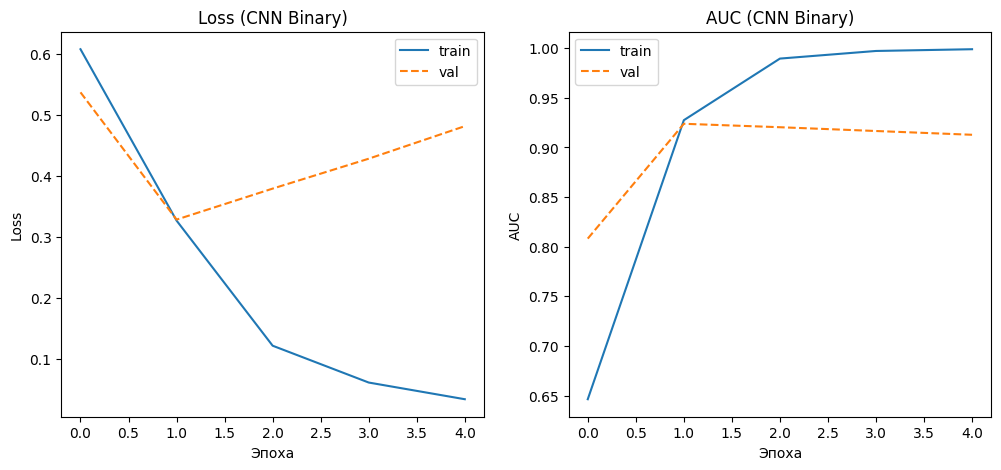

In [ ]:
def plot_history_binary(history, name='CNN-LSTM Binary'):
    plt.figure(figsize=(12,5))
    
    # Потеря
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], '--', label='val')
    plt.title(f'Loss ({name})')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    
    # AUC
    plt.subplot(1,2,2)
    plt.plot(history.history['AUC'], label='train')
    plt.plot(history.history['val_AUC'], '--', label='val')
    plt.title(f'AUC ({name})')
    plt.xlabel('Эпоха')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.show()

plot_history_binary(history_cnn_lstm_bin, 'CNN-LSTM Binary')
plot_history_binary(history_bin, 'LSTM Binary')
plot_history_binary(history_bin2, 'CNN Binary')


Лучше всего себя показала модель LSTM, будем использовать ее для приложения streamlit

## Сохранение моделей

In [ ]:
# Для мультиклассовой задачи
# model.save("cnn_lstm_multiclass.h5")
model2.save("lstm_multiclass.keras")
# model3.save("cnn_multiclass.h5")

# Для бинарной задачи
model_lstm.save("lstm_binary.keras")
# model_cnn.save("cnn_binary.h5")
# model_cnn_lstm_bin.save("cnn_lstm_binary.h5")